Si se agregan las predicciones de un grupo de predictores se tendran mejores resultados que solo con un solo predictor, un grupo de predictores se llama un ensemblaje, esta técnica se llama aprendizaje de ensemblaje, los algoritmos son llamados métodos de ensemblaje.

Al tener varios arboles de decisión entrenados en diferentes subgrupos del conjunto de entrenamiento, luego encontrar la predicción más usual es llamado `Random forest`, es uno de los algoritmos más poderosos.

## Voting classifiers

Si se tienen varios predictores, cada uno con un *accuracy* del 80%, por ejemplo una regresión logistica, un clasificador SVM, un random forest, etc. Una forma sencilla de crear un mejor predictor es agregar las predicciones, la clase que obtenga la mayoría de votos es la predicción del ensemblaje, este método se llama `hard voting classifier`, este método casi siempre logra un mejor *accuracy* que los predictores individuales.

Los metodos de ensamblaje funcionan mejor cuando los predictores son los más independientes que se puedan de los otros.

Scikit tiene la clase para esto `VotingClassifier`

In [1]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [2]:
X, y = make_moons(n_samples = 500, noise = 0.3, random_state = 42)
X_train,X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [3]:
voting_clf = VotingClassifier(
    estimators = [
        ('lr', LogisticRegression(random_state = 42)),
        ('rf', RandomForestClassifier(random_state = 42)),
        ('svc', SVC(random_state = 42))
    ]
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

Scikit clonea todos los estimadores y ajusta los clones. Los estimadores originales están disponibles via el atributo `estimators`, los clones ajustados están disponibles via el atributo `estimators_`, si se prefieren con nombres se pueden usar `named_estimators`, vamos a ver cada *accuracy* 

In [4]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, '=', clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


Cuando se llama el metodo `predict()` hacen *hard voting*

In [5]:
voting_clf.predict(X_test[:1])

array([1], dtype=int64)

In [6]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1], dtype=int64), array([1], dtype=int64), array([0], dtype=int64)]

In [7]:
voting_clf.score(X_test, y_test)

0.912

El clasificador por votos tiene un mejor rendimiento que todos los individuales.

Si todos los clasificadores tienen el metodo `predict_proba()` se le puede decir a scikit que prediga la clase con la más alta probabilidad, promediada sobre todas las clases individuales, esto se llama `soft voting`. Casi siempre produce mejor rendimiento que `hard voting` ya que le da más pesos a los votos muy confidentes, a continuación se hace un ejemplo, como el SVC no tiene `predict_proba()` se establece el hiperparámetro `probability = True` (hace que la clase use validación cruzada para estimar las probabilidades)

In [8]:
voting_clf.voting = 'soft'
voting_clf.named_estimators['svc'].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

## Bagging y pasting

Otra forma de tener un ensamblaje pero con el mismo algoritmo es usar el mismo algoritmo y entrenarlo en diferentes submuestras del conjunto de entrenamiento, si se hace con reemplazo se llama `bagging (bootstrap aggregating)`, si se hace sin reemplazo se llama `pasting`.

Una vez los predictores están entrenados el ensamble puede hacer una predicción agregando todas las predicciones, la *moda* para clasificación y un promedio para la regresión. Cada predictor tiene un sesgo alto, agregando todos se reduce el sesgo y la varianza. 

### En scikit 

Scikit ofrece una API para bagging y pasting: `BaggingClassifier (BaggingRegressor)`, el siguiente ejemplo entrena un ensamblaje de 500 arboles de decisión de clasificación, cada uno es entrenado en 100 observaciones de entrenamiento muestreadas aleatoriamente con reemplazo (si se quiere sin reemplazo `bootstrap = False`. El parámetro `n_jobs` le dice a scikit el numero de nucleos para usar para entrenamiento y predicción, -1 dice que se usen todos los disponibles.

In [9]:
from sklearn.ensemble import BaggingClassifier 
from sklearn.tree import DecisionTreeClassifier 

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators = 500,
                           max_samples = 100, n_jobs = -1, random_state = 42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

`BaggingClassifier` hace automaticamente *soft voting*.

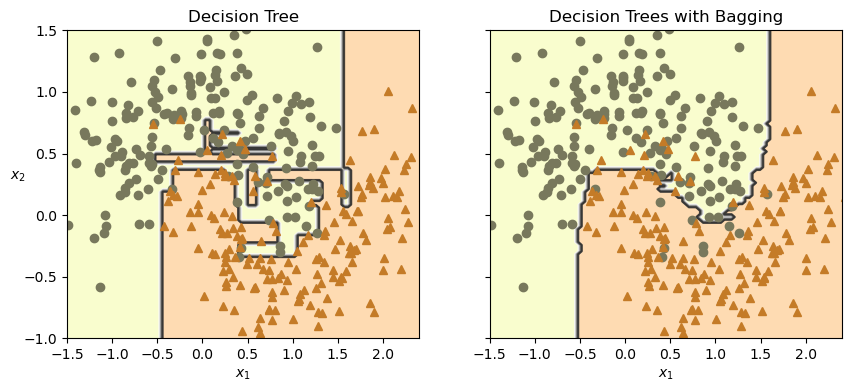

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
plt.show()

## Out of bag evaluation

Con bagging algunas observaciones puede que queden en la muestra varias veces y otras puede que no queden, se demuestra que aproximadamente el 63% de las observaciones se muestrean en promedio para cada predictor. Las observaciones que no quedan se llaman observaciones `out of bag`, estas no son las mismas para cada predictor.

Un ensamblaje puede ser evaluado usando las observaciones OOB sin necesidad de tener un conjunto de validación separado.

En scikit se puede establecer `oob_score = True` para crear un `BaggingClassifier` para hacer una evaluación OOB después de entrenamiento.

In [11]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators = 500,
                           oob_score = True, n_jobs = -1, random_state = 42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=500,
                  n_jobs=-1, oob_score=True, random_state=42)

In [12]:
bag_clf.oob_score_

0.896

In [13]:
from sklearn.metrics import accuracy_score 
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

La función de decisión del OOB está disponible con el atributo `oob_decision_function_`. Este estimador tiene metodo `predict_proba()`, por lo tanto la función de decisión devuelve las probabilidades de las clases

In [14]:
bag_clf.oob_decision_function_[:3]

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

## Parches aleatorios y subespacios aleatorios 

`BaggingClassifier` soporta muestrear las variables tambien, el muestreo de variables se controla con dos hiperparámetros `max_features`, `bootstrap_features`. Cada predictor se entrenará en una muestra aleatoria de variables.

Muestrear observaciones y variables se llama `parches aleatorios`. Quedarse con todas las observaciones (`bootstrap = False, max_samples = 1.0`) pero muestrear las variables (`bootstrap_features = True, max_features < 1`) es llamado `metodo subespacios aleatorios`.

## Random forest

Es un ensamblaje de varios arboles, generalmente entrenados con `bagging`, el siguiente ejemplo entrena 500 arboles, cada uno limitado a 16 nodos hoja usando todos los nucleos disponibles

In [15]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16,
                                n_jobs = -1, random_state = 42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

El random forest tiene todos los hiperparámetros de un árbol y además los de Bagging para controlar el ensamblaje.

En vez de buscar la mejor variables para separar el conjunto busca la mejor variable en un subgrupo aleatorio de variables, por default muestreo $\sqrt{n}$ variables, esto resulta en arboles muy diversos, cambiando un sesgo alto por varianza baja, un ejemplo de como se haría con la clase `BaggingClassifier`

In [16]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features = 'sqrt', max_leaf_nodes = 16),
    n_estimators = 500, n_jobs = -1, random_state = 42
)

## Arboles extra

En cada nodo solo unas variables aleatorias se tienen en cuenta para hacer la división, para hacer los arboles más aleatorios se puede usar un limite aleatorio para cada variable en vez de buscar por el mejor limite posible, para esto establecemos `splitter = 'random'`.

Un árbol tan extremo es llamado `extremely randomized tree`, esta tecnica intercambia sesgo por menos varianza, igualmente hace que correr el modelo sea más rápido.

Se puede crear con la clase `ExtraTreesClassifier`, en esta clase es identica a RandomForestClassifier, pero el parámetro `bootstrap` está establecido en falso por defecto, igualmente existe `ExtraTreesRegressor`.

No se sabe con seguridad qué modelo es mejor, lo mejor es hacer ambos y compararlos con validación cruzada.

## Importancia de las variables

Una de las cosas buenas que tienen los random forest es que hacen facil medir la importancia relativa de cada variable. Scikit mide esta importancia viendo que tanto los nodos de los arboles que usan esa variable reducen la impureza en promedio, en todos los árboles. 

Scikit computa este puntaje automaticamente para cada variable luego del entrenamiento, luego la escala para que la suma de las importancias sea igual a 1, se puede acceder a esto con `feature_importances_`, por ejemplo,

In [17]:
from sklearn.datasets import load_iris
iris = load_iris(as_frame = True)
rnd_clf = RandomForestClassifier(n_estimators = 500, random_state = 42)
rnd_clf.fit(iris.data, iris.target)

for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


Similar si se entrena un random forest en el dataset MNIST y se grafíca la importancia de cada pizel se tiene la siguiente imagen.

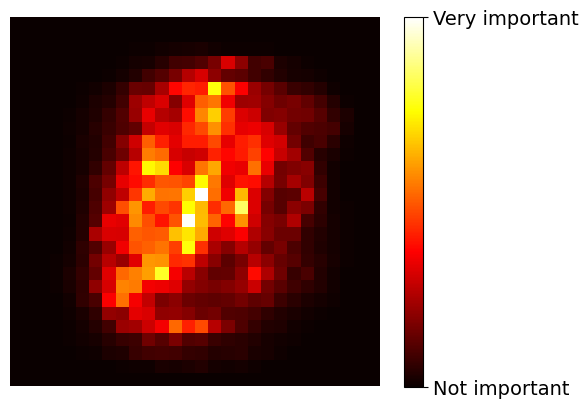

In [18]:
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
plt.show()

## Boosting

Se refiere la cualquier metodo en ensamble que combine varios *weak lerners* en un *strong lerner*. La idea principal es entrenar los predictores secuencialmente, cada uno tratando de mejorar el predecesor, los `boosting` más populares son `Adaboost` y `gradient boost`.

### Adaboost

Para corrregir el predecesor se presta más atención a las observaciones que el predecesor subestimó, resultando en predictores que se enfocan más y más en los casos dificiles. Esta es la tecnica usada en AdaBoost.

Al entrenar un clasificador AdaBoost, el algoritmo entrena un modelo base y usa las predicciones en el conjunto de entrenamiento. El algoritmo incrementa los pesos de las observaciones de entrenamiento mal clasificadas y luego entrena un segundo clasificador usando los pesos actualizados y así iterativamente.

Una vez los predictores estan entrenados, el ensamblaje hace predicciones como bagging o pasting, pero los predictores tienen diferentes pesos dependiendo en su *accuracy* en el conjunto de entrenamiento.

Así es el algoritmo de AdaBoost, el peso de cada instancia $w^{(i)}$ es inicialmente $1/m$. Un primer predictor es entrenado y su tasa de error promediada $r_1$ es computada en el conjunto de entrenamiento.

$$
r_j = \sum_{i=1}^m w^{(i)} \\
\hat{y}_j \neq y^{(i)}
$$

El peso del predictor $\alpha_j$ es computado con la siguiente ecuación,

$$
\alpha_j = \eta\log\frac{1-r_j}{r_j}
$$

Donde $\eta$ es la tasa de aprendizaje (por defecto 1). Entre más preciso es el predictor más grande va a ser el peso, si casi siempre está equivocado el peso va a ser negativo.

Luego el AdaBoost actualiza los pesos de las observaciones usando la siguiente ecuación,

$\begin{aligned} & \text { for } i=1,2, \cdots, m \\ & w^{(i)} \leftarrow \begin{cases}w^{(i)} & \text { if } \widehat{y}_j^{(i)}=y^{(i)} \\ w^{(i)} \exp \left(\alpha_j\right) & \text { if }{\widehat{y_j}}^{(i)} \neq y^{(i)}\end{cases} \end{aligned}$

Luego todas las instancias son normalizadas (divididas por $\sum w^{(i)}$.

Finalmente en nuevo predictor es entrenado usando los pesos actualizados y el proceso se repite. El proceso se detiene cuando el numero deseado de predictores se alcance o cuando un predictor perfecto se encuentre.

Para hacer predicciones se computan las predicciones de todos los predictores y los pesos usando los pesos del predictor $\alpha_j$, la clase predicha es la que reciba la mayoria de los votos ponderados.

$\widehat{y}(\mathbf{x})=\underset{k}{\operatorname{argmax}} \sum_{\substack{j=1 \\ \hat{y}_j(\mathbf{x})=k}}^N \alpha_j$ where $N$ is the number of predictors

scikit usa una versión de Adaboost multiclase llamada `SAMME`, cuando hay dos clases SAMME es equivalente a Adaboost. Si los predictores pueden estimar las probabilidades de las clases (tienen el metodo `predict_proba()`) scikit usa `SAMME.R`, el cual depende en las probabilidades de las clases en vez de predicciones y generalmente rinde mejor.

Como ejemplo se entrena un AdabBoost basado en 30 *decision stumps* usando la clase AdaBoostClassifier

In [19]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth = 1), n_estimators = 30,
    learning_rate = 0.5, random_state = 42)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

Si en el ensamblaje Adaboost está sobreajustando se pueden reducir el numero de estimadores o regularizar el estimador base.

## Gradient boosting

Funciona bajo la misma premisa, añade predictores cada uno mejorando al predecesor, este metodo intenta ajustar nuevos predictores a los errores residuales hechos por el predictor anterior.

Un ejemplo de regresión usando decision trees como predictores base, esto es llamado `gradient tree boosting`

In [20]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100) # y = 3x^2 + ruido gaussiano

In [21]:
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [22]:
# Ahora se entrena otro arbol en los errores residuales del primero

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

In [23]:
# otra vez

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

In [24]:
# ahora se hace la predicción sumando las predicciones de los tres

X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

Podemos ver el cambio en la siguiente gráfica

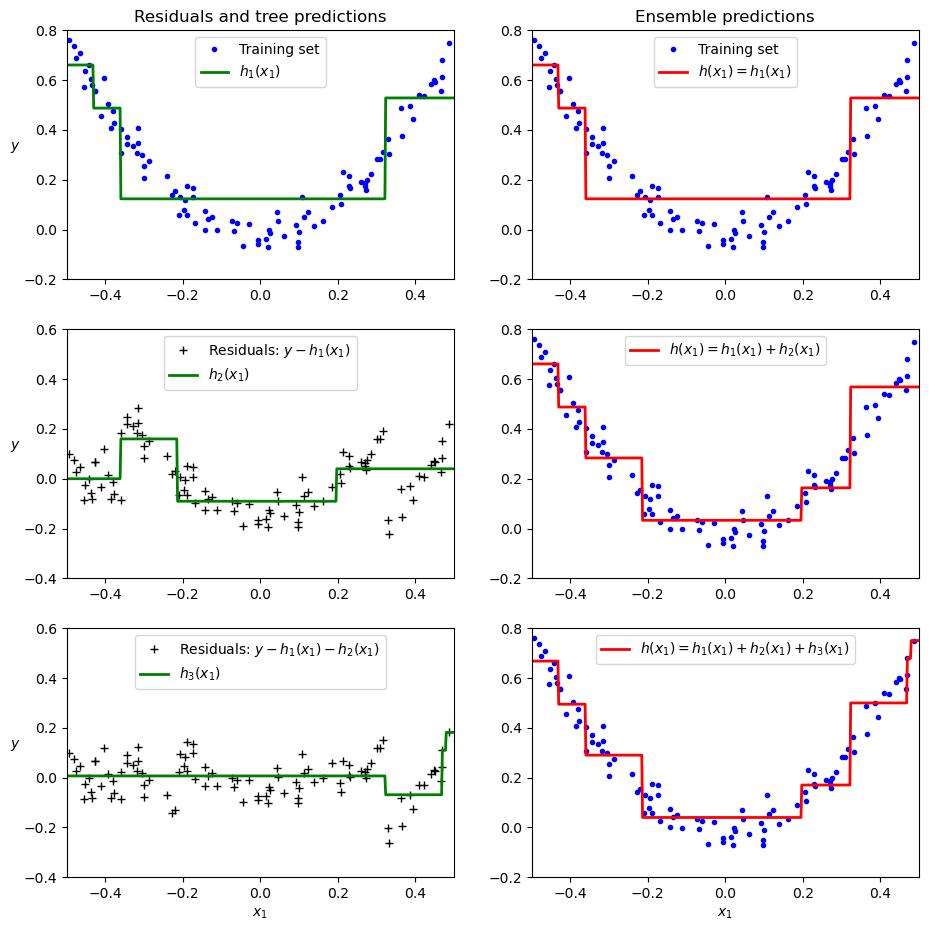

In [25]:
def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuals and tree predictions")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.title("Ensemble predictions")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

plt.show()

Se puede usar la clase `GradientBoostingRegressor` para entrenar ensamblajes más facil, esta clase tiene hiperparámetros para controlar el creciemiento de los arboles y para controlar el entrenamiento del ensamblaje.

In [26]:
from sklearn.ensemble import GradientBoostingRegressor 

gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators = 3,
                                learning_rate = 1.0, random_state = 42)

gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

La tasa de aprendizaje escala la contribución de cada árbol, si se establece en un valor bajo se necesitaran más arboles en el ensamblaje para ajustar los datos de entrenamiento, pero las predicciones generalizaran mejor. Esto es una tecnica de regularización llamada `encogimiento`

Para encontrar el numero óptimos de árboles se puede usar una validación cruzada pero hay una forma más sencilla, si se establece `n_iter_no_change` a un valor entero, el modelo para automaticamente si los ultimos 10 arboles no ayudaron.

In [27]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)

gbrt_best.n_estimators_

92

Si se establece `n_iter_no_change` muy bajo el entrenamiento puede parar muy rápido y subajustar los datos, si se establece muy alto va a sobreajustar. Pero vemos que el numero de estimadores es mucho menor gracias a la parada temprana.

Cuando `n_iter_no_change` es establecido el metodo `fit()` automaticamente divide el conjunto en entrenamiento y validación, lo que le permite evaluar el modelo cada vez que agrega un árbol, el tamano de validación se controla con el hiperarámetro `validation_fraction`, el hiperparámetro `tol` determina la maxima mejora de rendimiento que cuenta para la iteración.

Tambien se tiene otro hiperparámetro `subsample` especifica la fracción de observaciones de entrenamiento para ser usadas en cada arbol, esta tecninca intercambia sesgo por menor varianza, esto es llamado `stochastic gradient boosting`.

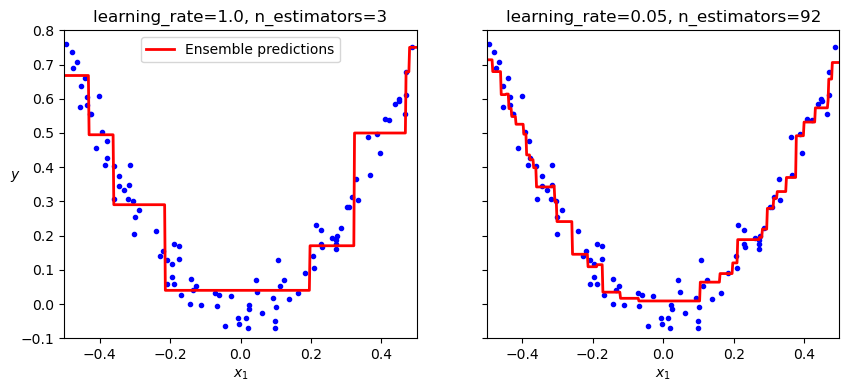

In [28]:

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="Ensemble predictions")
plt.title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"learning_rate={gbrt_best.learning_rate}, "
          f"n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$")

plt.show()

In [29]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

### Histogram-Based Gradient Boosting

Scikit tiene otra implementación para GBRT optimizada para datos largos basada en histogramas. 

Funciona agrupando las variables de entrada reemplzandolas por enteros, el numero de bins es controlado con el hiperparámetro `max_bins` el cual tiene por defecto 255 y no puede ser mas alto.

HGB entrena cientos de veces más rápido que GBRT, sin embargo produce perdida de precisión, lo cual actua como una regularización: dependiendo en los datos esto puede ayudar a reducir el sobreajuste o puede producir subajuste.

Scikit tiene dos clases para HGB, `HistGradientBoostingRegressor` y `HistGradientBoostingClassifier`, son similares a `GradientBoosting` con unas diferencias:

- La parada temprana es activada automaticamente si el numero de instancias es mayor a 10000, se puede ajustar con el hiperparámetro `early_stopping`.

- Submuestreo no está permitido.

- `n_estimators` se llama `max_iter`.

- El unico hiperparámetro de los árboles que se puede cambiar son `max_leaf_nodes`, `min_samples_leaf` y `max_depth`.

La clase HGB soporta variables categóricas y valores perdidos, sin embargo, las variables categóricas deben ser representadas con enteros con rango de 0 a un número menor que max_bins. Se puede usar `OrdinalEncoder` para esto, por ejemplo:

In [30]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder


hgb_reg = make_pipeline(
    make_column_transformer((OrdinalEncoder(), ['ocean_proximity']),
                           remainder = 'passthrough'),
    HistGradientBoostingRegressor(categorical_features = [0], random_state = 42)
)

`categorical_features` debe ser establecida a los indices de las variables categoricas ( o un arreglo booleano )

In [31]:
import os
os.chdir("C:/Users/Usuario/OneDrive - Universidad Nacional de Colombia/Escritorio/Clases/Machine learning/Machine learning - python")

In [32]:
import os
import tarfile
from six.moves import urllib

In [33]:
DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/blob/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
ADDITIONAL_PARAM = "?raw=true"
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz" + ADDITIONAL_PARAM

In [34]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [35]:
fetch_housing_data()

In [36]:
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [37]:
housing = load_housing_data()

In [38]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
housing_labels = train_set["median_house_value"]
housing = train_set.drop("median_house_value", axis=1)

In [39]:
hgb_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['ocean_proximity'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=[0],
                                               random_state=42))])

In [40]:
from sklearn.model_selection import cross_val_score

hgb_rmses = -cross_val_score(hgb_reg, housing, housing_labels,
                             scoring="neg_root_mean_squared_error", cv=10)
pd.Series(hgb_rmses).describe()

count       10.000000
mean     47816.628527
std       1701.518527
min      45302.929913
25%      46442.839737
50%      48389.882366
75%      49233.660147
max      49724.913978
dtype: float64

Otros ecosistemas están disponibles en python, los más importantes son: `XGBoost`, `CatBoost` y `LightGBM`.

## Stacking

Este metodo de ensamblaje se basa en, en vez de usar funciones triviales (como hard voting) para agregar las predicciones, por qué no se entrena un modelo para agregar las predicciones, por ejemplo en esta figura se tienen 3 predictores que predicen diferentes valores (3.1, 2.7 y 2.9), luego un predictor final (llamado *blender* o *meta lerner*) toma las predicciones como inputs y hace una predicción final.

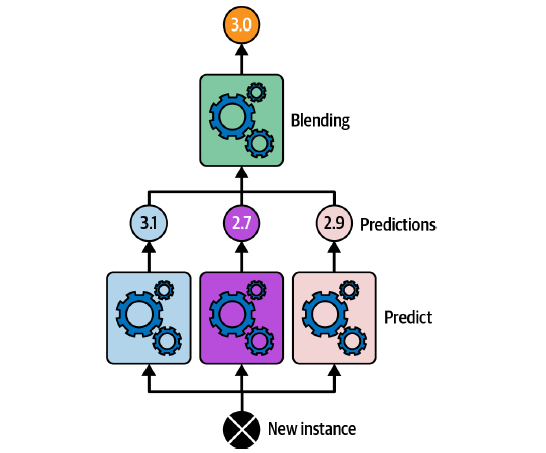

Para entrenar el *blender* primero se necesita construir un conjunto de entrenamiento para el *blender*. Se puede usar `cross_val_predict()` en cada predictor para obtener las predicciones *out-of-sample* para cada observación en el conjunto de entrenamiento original y usar estos para variables inputs para entrenar al *blender*, las targets pueden ser solo copiadas de conjunto de entrenamiento original.

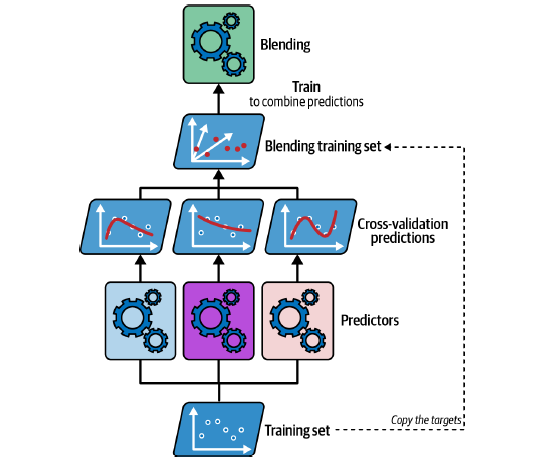

Es posible entrenar varios *blenders* para obtener una capa de blenders y añadir otro *blender* encima para producir la predicción final,

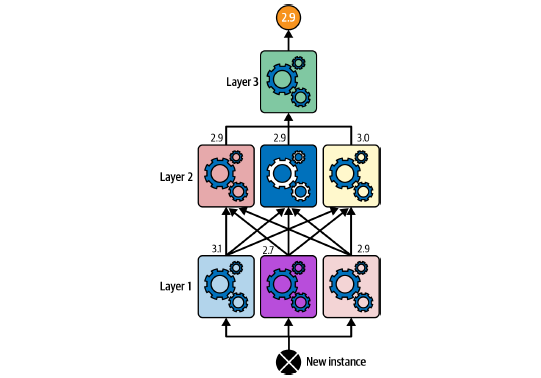

Se puede mejorar un poco el rendimiento pero cuesta tiempo de entrenamiento y complejidad del sistema.

Scikit tiene `StackingClassifier` y `StackingRegressor`

In [41]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators = [
        ('lr', LogisticRegression(random_state = 42)),
        ('rf', RandomForestClassifier(random_state = 42)),
        ('svc', SVC(probability = True, random_state = 42))
    ],
    final_estimator = RandomForestClassifier(random_state = 43),
    cv = 5
)

stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

In [42]:
stacking_clf.score(X_test, y_test)

0.928

Para cada predictor, se llama `predict_proba()` si está disponible, si no, llama `decision_function()`, como ultimo recurso llama `predict()`. Si no se da un estimador final el clasificador usa `LogisticRegression`, el regresor `RidgeCV`.

Los metodos de ensamble son versatiles, poderosos y simples de usar.

## Ejercicios

1. If you have trained five different models on the exact same training data, and they all achieve 95% precision, is there any chance that you can combine these models to get better results? If so, how? If not, why?

Si, al combinarse los modelos se puede obtener una mejor precisión, esto debido a que tener más modelos siempre va a ser mejor que tener sólo 1. Entre más diferentes los modelos o si están entrenados con datos diferentes mejor, los modelos van a tener errores diferentes y se complementan.

2. What is the difference between hard and soft voting classifiers?

Hard voting es sacar la moda de los modelos, escoger la clase que tenga más votos. El soft voting usa la probabilidad promedio de cada clase, dandole más importancia a las clases con una probabilidad muy alta, casi siempre da mejores resultados.

3. Is it possible to speed up training of a bagging ensemble by distributing it across multiple servers? What about pasting ensembles, boosting ensembles, random forests, or stacking ensembles?

Si es posible acelerar el entrenamiento de un bagging distribuyendolo en varios servidores ya que cada predictor es independiente del anterior, lo mismo para RandomForest y pasting. Para un boosting, cada predictor depende del anterior, por lo tanto no se gana nada distribuyendolos en servidores diferentes. Para stacking todos los predictores en una capa son independientes de los otros, por lo que pueden ser entrenados en diferentes servidores, los predictores en una capa solo pueden ser entrenados despues de que todos los de la capa anterior hayan sido entrenados.

4. What is the benefit of out-of-bag evaluation?

El beneficio de la evaluación OOB es que no hay necesidad de separar el conjunto de entrenamiento en validación, se hace una validación en cada itearción del entrenamiento.

5. What makes extra-trees ensembles more random than regular random forests? How can this extra randomness help? Are extra-trees classifiers slower or faster than regular random forests?

Además de usar observaciones y variables aleatorias también se aleatoriza el limite con el que los nodos se separan, en vez de buscar un óptimo encuentra un limite aleatorio, esto ayuda a que sea mucho más rápidos ya que el proceso más lento de una árbol de decisión es encontrar este óptimo de separación. Esta aleatorización extra funciona como regularización, si un random forest sobreajusta los datos es posible que extra trees tenga mejor rendimiento.

6. If your AdaBoost ensemble underfits the training data, which hyperparameters should you tweak, and how?

Si en el ensamblaje Adaboost está subajustando se pueden aumentar el numero de estimadores o reducir la regularización del estimador base, también reducir un poco la tasa de aprendizaje.

7. If your gradient boosting ensemble overfits the training set, should you increase or decrease the learning rate?

Se debería tratar de incrementar la tasa de aprendizaje, también se puede usar parada temprana para encontrar el numero correcto de predictores.

8. Load the MNIST dataset (introduced in Chapter 3), and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing). Then train various classifiers, such as a random forest classifier, an extra-trees classifier, and an SVM classifier. Next, try to combine them into an ensemble that outperforms each individual classifier on the validation set, using soft or hard voting. Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?

In [43]:
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False)

In [44]:
X_train, y_train = X_mnist[:50000], y_mnist[:50000]
X_valid, y_valid = X_mnist[50_000:60_000], y_mnist[50_000:60_000]
X_test, y_test = X_mnist[60_000:], y_mnist[60_000:]

In [45]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [46]:
random_forest_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
extra_trees_clf = ExtraTreesClassifier(n_estimators = 100, random_state = 42)
svm_clf = LinearSVC(max_iter = 100, tol = 20, random_state = 42)
mlp_clf = MLPClassifier(random_state = 42)

In [47]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]

for estimator in estimators:
    print('Entrenando el', estimator)
    estimator.fit(X_train, y_train)

Entrenando el RandomForestClassifier(random_state=42)
Entrenando el ExtraTreesClassifier(random_state=42)
Entrenando el LinearSVC(max_iter=100, random_state=42, tol=20)
Entrenando el MLPClassifier(random_state=42)


In [48]:
[estimator.score(X_valid, y_valid) for estimator in estimators]

[0.9736, 0.9743, 0.8662, 0.9639]

In [49]:
from sklearn.ensemble import VotingClassifier

named_estimators = [
    ('random_forest_clf', random_forest_clf),
    ('extra_trees_clf', extra_trees_clf),
    ('svm_clf', svm_clf),
    ('mlp_clf', mlp_clf),
]

In [51]:
voting_clf = VotingClassifier(named_estimators)

In [53]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf',
                              LinearSVC(max_iter=100, random_state=42, tol=20)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [54]:
voting_clf.score(X_valid, y_valid)

0.9758

El `VotingClassifier` hizo un clon de cada clasificador y entrenó los clasificadores usando los indices de cada clase como labels, no los nombres originales de las clases. Para evaluar estos clones necesitamos dar los indices de las clases también, para convertir las clases a los indices de clases se usa `LabelEncoder`

In [59]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_valid_encoded = encoder.fit_transform(y_valid)

In [60]:
y_valid_encoded = y_valid.astype(np.int64)

In [61]:
[estimator.score(X_valid, y_valid_encoded)
    for estimator in voting_clf.estimators_]

[0.9736, 0.9743, 0.8662, 0.9639]

Se va a quitar el clasificador SVM ya que tiene un rendimiento bajo.

In [62]:
voting_clf.set_params(svm_clf = 'drop')

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', 'drop'),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [63]:
voting_clf.estimators

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('svm_clf', 'drop'),
 ('mlp_clf', MLPClassifier(random_state=42))]

In [64]:
# no actualizó la lista de estimadores entrenados

voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(max_iter=100, random_state=42, tol=20),
 MLPClassifier(random_state=42)]

In [65]:
# Toca ajustar otra vez el VotingClassifier o quitar el SVM de la lista de estimadores entrenados 

svm_clf_trained = voting_clf.named_estimators_.pop('svm_clf')
voting_clf.estimators_.remove(svm_clf_trained)

In [66]:
# se evalua otra vez

voting_clf.score(X_valid, y_valid)

0.9764

In [67]:
# Mejora un poco, ahora se intenta con soft voting

voting_clf.voting = 'soft'
voting_clf.score(X_valid, y_valid)

0.9697

In [68]:
# es mejor el hard voting

voting_clf.voting = 'hard'
voting_clf.score(X_test, y_test)

0.9729

In [69]:
[estimator.score(X_test, y_test.astype(np.int64))
    for estimator in voting_clf.estimators_]

[0.968, 0.9703, 0.9671]

El clasificador por votos rinde mejor que todos los individuales.

9. Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image’s class. Train a classifier on this new training set. Congratulations—you have just trained a blender, and together with the classifiers it forms a stacking ensemble! Now evaluate the ensemble on the test set. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble’s predictions. How does it compare to the voting classifier you trained earlier? Now try again using a StackingClassifier instead. Do you get better performance? If so, why?

In [73]:
X_valid_predictions = np.empty((len(X_valid), len(estimators)), dtype = object)

for index, estimator in enumerate(estimators):
    X_valid_predictions[:, index] = estimator.predict(X_valid)

In [74]:
rnd_forest_blender = RandomForestClassifier(n_estimators = 200, oob_score = True,
                                           random_state = 42)
rnd_forest_blender.fit(X_valid_predictions, y_valid)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [75]:
rnd_forest_blender.oob_score_

0.9728

In [76]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=object)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [77]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [78]:
accuracy_score(y_test, y_pred)

0.9699

Este modelo stacking no es mejor que los clasificadores por voto, ahora vamos a usar `StackingClassifier`, como `StackingClassifier` usa validación cruzada no hay que crear un set de validación.

In [79]:
X_train_full, y_train_full = X_mnist[:60_000], y_mnist[:60_000]

In [80]:
stack_clf = StackingClassifier(named_estimators,
                              final_estimator = rnd_forest_blender)
stack_clf.fit(X_train_full, y_train_full)

StackingClassifier(estimators=[('random_forest_clf',
                                RandomForestClassifier(random_state=42)),
                               ('extra_trees_clf',
                                ExtraTreesClassifier(random_state=42)),
                               ('svm_clf',
                                LinearSVC(max_iter=100, random_state=42,
                                          tol=20)),
                               ('mlp_clf', MLPClassifier(random_state=42))],
                   final_estimator=RandomForestClassifier(n_estimators=200,
                                                          oob_score=True,
                                                          random_state=42))

In [81]:
stack_clf.score(X_test, y_test)

0.9809

Mejoró mucho, se puede dar porque:

- Se entrenó en un conjunto más grande.
- Usó `predict_proba()`, o `decision_function()` o `predict()`, le da al blender mas inputs para trabajar